这是李宏毅[GAN课程](https://www.youtube.com/watch?v=DQNNMiAP5lw)的学习笔记

In [1]:
import torch.nn as nn
import torch
from torch import optim
from torch.autograd import Variable
import torchvision

![image.png](https://i-blog.csdnimg.cn/blog_migrate/fcf7cf87abbc78b0e4bdd28de26c8dd4.png#pic_center)

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:#find() 返回字符串第一次出现的索引，如果没有匹配项则返回-1
        m.weight.data.normal_(0.0, 0.02)#归一化
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class G(nn.Module):
    def __init__(self,in_dims=1024,out_dim=512):
        # in_dims指的是输出的随机向量的维度 ; out_dims指的是输出图像的尺寸
        super(G,self).__init__()
        self.model=nn.Sequential()

        self.fn1=nn.Sequential(nn.Linear(in_dims,out_dim*64*64*4),
                               nn.BatchNorm1d(out_dim*64*64*4),
                               nn.ReLU()) #经过第一层线性层之后记得reshape为64*64*1024的形状
        
        self.arcconv1=nn.ConvTranspose2d(in_channels=2048,out_channels=1024,kernel_size=5,stride=4,padding=2,output_padding=3)
        self.rl1=nn.ReLU()
        self.arcconv2=nn.ConvTranspose2d(in_channels=1024,out_channels=256,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.rl2=nn.ReLU()
        self.arcconv3=nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.rl3=nn.ReLU()
        self.arcconv4=nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.rl4=nn.Tanh()

        self.fn2=nn.Sequential(self.arcconv1,self.rl1,self.arcconv2,self.rl2,self.arcconv3,self.rl3,self.arcconv4,self.rl4)

        self.apply(weights_init)
        

    def forward(self,x):
        z=self.fn1(x)
        z=z.view(-1,2048,64,64)
        z=self.fn2(z)
        return z

In [3]:
class D(nn.Module):
    def __init__(self,in_dims=3,dims=64):
        # 输入的数据格式应该是  N*3*512*512
        super(D, self).__init__()
        
        self.model = nn.Sequential()

        def conv_binary_2d(in_dim,out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim,out_dim,5,2,2),
                nn.BatchNorm2d(out_dim),nn.LeakyReLU(0.15)
            )
        self.model.append(nn.Conv2d(in_dims, dims, 10, 8, 1))
        self.model.append(nn.LeakyReLU(0.1))
        self.model.append(conv_binary_2d(dims,2*dims))
        self.model.append(conv_binary_2d(2*dims,4*dims))
        self.model.append(conv_binary_2d(4*dims,8*dims))
        self.model.append(conv_binary_2d(8*dims,16*dims))
        self.model.append(nn.Conv2d(16*dims,1,4))
        self.model.append(nn.Sigmoid())
        self.apply(weights_init)
    
    def forward(self,x):
        # 返回是一个batch-size的一维数组
        z=self.model(x)
        z=z.view(-1)
        return z

In [4]:
# 开始训练！
import os

batch_size=32
feature_dim=128 #设置特征向量的大小

lr=5e-5
n_epoch=100

workspace_dir = '.'
save_dir=os.path.join(workspace_dir,'logs')
os.makedirs(save_dir,exist_ok=True)

G_model = G(in_dims=feature_dim).cuda()
D_model = D(3).cuda()
G_model.train()
D_model.train()


D(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(8, 8), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.15)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.15)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.15)
    )
    (5): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05,

In [5]:
criterion=nn.BCELoss()

# optimizer
opt_D = torch.optim.Adam(D_model.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G_model.parameters(), lr=lr, betas=(0.5, 0.999))

import random
import numpy as np
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x1426E9F9C70>
tensor([[[0.6510, 0.6510, 0.6510,  ..., 0.9373, 0.9333, 0.9333],
         [0.6510, 0.6510, 0.6510,  ..., 0.9333, 0.9294, 0.9294],
         [0.6510, 0.6510, 0.6431,  ..., 0.9373, 0.9333, 0.9294],
         ...,
         [0.6471, 0.6392, 0.6353,  ..., 0.9294, 0.9294, 0.9255],
         [0.6627, 0.6549, 0.6431,  ..., 0.9255, 0.9255, 0.9216],
         [0.6706, 0.6588, 0.6471,  ..., 0.9216, 0.9216, 0.9216]],

        [[0.6706, 0.6706, 0.6706,  ..., 0.9529, 0.9490, 0.9490],
         [0.6706, 0.6706, 0.6706,  ..., 0.9490, 0.9451, 0.9451],
         [0.6706, 0.6706, 0.6706,  ..., 0.9412, 0.9373, 0.9333],
         ...,
         [0.7412, 0.7412, 0.7451,  ..., 0.8431, 0.8431, 0.8392],
         [0.7333, 0.7373, 0.7373,  ..., 0.8392, 0.8392, 0.8353],
         [0.7255, 0.7294, 0.7373,  ..., 0.8353, 0.8353, 0.8353]],

        [[0.5922, 0.5922, 0.5922,  ..., 0.9569, 0.9608, 0.9608],
         [0.5922, 0.5922, 0.5922,  ..., 0.

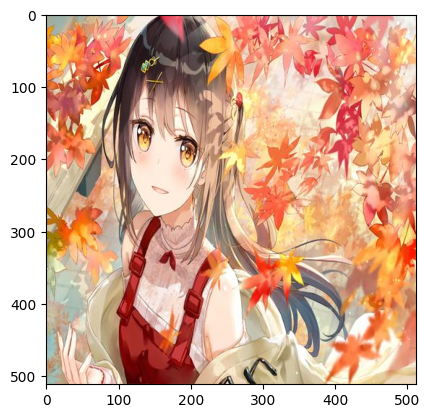

In [6]:
from torch.utils.data import Dataset, DataLoader
import glob
import os
import torchvision.transforms as transforms
from PIL import Image

class GAN_dataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        :param image_dir: 存储图像的目录
        :param transform: 可选的转换操作
        """
        
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        print(image)
        if self.transform:
            image = self.transform(image)

        return image

#这里可以加载自己想加载的数据
def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # resize the image to (64, 64)
    # linearly map [0, 1] to [-1, 1]线性转换

    #transform这个我前面的作业解释的很清楚，
    #这就不再重复解释了，看过一遍就会觉得很简单
    t = transforms.ToTensor()
    dataset = GAN_dataset(root, transform=t)
    return dataset

dataset = get_dataset(os.path.join(workspace_dir, 'raw_GAN'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

import matplotlib.pyplot as plt
print(dataset[999])
plt.imshow(dataset[999].permute(1, 2, 0))


In [8]:
images = []
# 测试模型运行
# 获取数据集切片并转换为 Tensor
for i in range(10, 20):
    img_tensor = dataset[i]  # 获取单张图像 Tensor
    images.append(img_tensor)

# 将列表中的图像堆叠为一个批次 Tensor
batch = torch.stack(images)  # 形状为 (batch_size, C, H, W)
batch=batch.to("cuda")
output = D_model(batch)
print(output)

test_input=torch.rand(5,feature_dim).to('cuda')
output=G_model(test_input)
print(output)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142704DC520>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9580>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9160>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x142542E9580>
tensor([0.9093, 0.9493, 0.9535, 0.9782, 0.2842, 0.8871, 0.8971, 0.0756, 0.7297,
        0.9207], device='cuda:0', grad_fn=<ViewBackward0>)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.25 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.32 GiB is allocated by PyTorch, and 50.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)